In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from scipy.optimize import curve_fit 
import scipy.integrate as integrate
import scipy.special as special
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D







from collections import OrderedDict


In [2]:
tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
#absorp_tab = Table.read('../3D_CMZ/LBV_plots_stuff/absorption_table_merged.tex')

cat_index = tab['leaf_id']
cloud_name = tab['cloud_name']
corr_coeff = tab['corr_coeff']
flux_diff = tab['flux_diff']
fdiff_stdv = tab['flux_diff_stdv']
flux_ratio = tab['flux_ratio']
fratio_stdv = tab['flux_ratio_stdv']
absorp_value = tab['absorp_value']



In [3]:
tab[20]

leaf_id,cloud_name,l,b,v,sigma,rad,corr_coeff,flux_diff,flux_diff_stdv,flux_ratio,flux_ratio_stdv,absorp_value,NF_decision,absorp_NF,lb_pixel_mask
str3,str14,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,str3,str3,int64
14,G0.105-0.08,0.105,-0.08,53,9,1.7,0.5,38.65,46.25,0.48,0.14,1.14,N,N,1


In [4]:
print(np.nanmax(flux_diff), np.nanmin(flux_diff))
print(np.nanmax(flux_ratio), np.nanmin(flux_ratio))

126.73 -125.23
1.0 -0.06


In [5]:
# normalize the data value between -1 and 1 for the 
# flux difference list 
# but need to center it on -52
fdiff_cn = 2. * ((-52 - np.nanmin(flux_diff)) / (np.nanmax(flux_diff) - np.nanmin(flux_diff))) - 1.
fdiff_stdv_centered = fdiff_stdv 

# flux ratio is centered on 0.699
fratio_cn = 2. * ((0.699 - np.nanmin(flux_ratio)) / (np.nanmax(flux_ratio) - np.nanmin(flux_ratio))) - 1.
fratio_stdv_centered = (fratio_stdv)

# Absorption centered on 1.
absorp_cn = 2. * ((1. - np.nanmin(absorp_value)) / (3.5 - np.nanmin(absorp_value))) - 1.

flux_ratio_normed = []
flux_diff_normed = []
fdiff_stdv_normed = []
fratio_stdv_normed = []
absorp_normed = []

for i in range(len(cat_index)):
    
    ###FDIFF NORMING 
    z_fdiff_i = 2. * ((flux_diff[i] - np.nanmin(flux_diff)) / (np.nanmax(flux_diff) - np.nanmin(flux_diff))) - 1.
    flux_diff_normed.append(z_fdiff_i-fdiff_cn) 
    
    z_fdiff_stdv_i = 2. * ((fdiff_stdv_centered[i] - np.nanmin(flux_diff)) / (np.nanmax(flux_diff) - np.nanmin(flux_diff))) - 1.
    fdiff_stdv_normed.append(z_fdiff_stdv_i-fdiff_cn)
    
    ###FRATIO NORMING 
    z_i = 2. * ((flux_ratio[i] - np.nanmin(flux_ratio)) / (np.nanmax(flux_ratio) - np.nanmin(flux_ratio))) - 1.
    flux_ratio_normed.append(-(z_i-fratio_cn)) 
    
    z_fratio_stdv_i = 2. * ((fratio_stdv_centered[i] - np.nanmin(flux_ratio)) / (np.nanmax(flux_ratio) - np.nanmin(flux_ratio))) - 1.
    fratio_stdv_normed.append(-(z_fratio_stdv_i-fratio_cn))
    
    ###ABSORP NORMING 
    if np.isnan(absorp_value[i]) == False:
        z_i_absorp = 2. * ((absorp_value[i] -np.nanmin(absorp_value)) / (3.5 - np.nanmin(absorp_value))) - 1.
        absorp_normed.append(-(z_i_absorp-absorp_cn))
    if np.isnan(absorp_value[i]) == True:
        absorp_normed.append(np.nan)
        


In [6]:


(2. * ((np.nanmin(flux_diff) - np.nanmin(flux_diff)) / (np.nanmax(flux_diff) - np.nanmin(flux_diff))) - 1.)-fdiff_cn

-0.5812827432925861

In [7]:
z = 2. * ((0.66 - np.nanmin(flux_ratio)) / (np.nanmax(flux_ratio) - np.nanmin(flux_ratio))) - 1.
-(z-fratio_cn)

0.07358490566037723

In [8]:
print(flux_diff_normed[19], flux_ratio_normed[19])
print(flux_diff_normed[20], flux_ratio_normed[20])

0.30703286235910454 -0.0018867924528302993
0.7195586601047784 0.4132075471698111


In [35]:
def corr_coeff_gauss_dist(x, mu):
    if np.isnan(mu)==True:
        return x*np.nan

    if (mu < 0) or (mu > 0.3):
        sigma = np.nanstd(corr_coeff)
    if (mu < 0.3) & (mu >= 0):
        sigma = np.nanstd(3.*corr_coeff)
    
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return   exp 


def flux_diff_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)
    #factor = 1./( sigma * np.sqrt(2.*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
    return    exp 



def flux_ratio_gauss_dist(x, mu, sigma):
    sigma=abs(sigma)  
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return      exp 


def absorp_gauss_dist(x, mu):
    sigma = np.nanstd(absorp_normed, where=np.array(absorp_value)<3.5)     
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return     exp 


def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

In [36]:
x = np.arange(-20,20, 0.01)


class ppdf:
        
    def __init__(self, cloud_id):
        x = np.arange(-20,20, 0.01)

        cat_id = np.where(cat_index == cloud_id)[0][0]

        if np.isnan(corr_coeff[cat_id])==False:
            r_dist = corr_coeff_gauss_dist(x, corr_coeff[cat_id]) 
            r_norm = integrate.quad(corr_coeff_gauss_dist, -np.inf, np.inf, args=(corr_coeff[cat_id]))[0]
            r_dist      /=  r_norm 
            self.corr_coeff = r_dist 

        if np.isnan(absorp_normed[cat_id])==False:
            absorp_dist = absorp_gauss_dist(x, absorp_normed[cat_id])
            absorp_norm = integrate.quad(absorp_gauss_dist, -np.inf, np.inf, args=(absorp_normed[cat_id]))[0]
            absorp_dist /=  absorp_norm
            self.absorp = absorp_dist 


        fratio_dist = flux_ratio_gauss_dist(x, flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id])
        fratio_norm = integrate.quad(flux_ratio_gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id]))[0]
        fratio_dist /=  fratio_norm 
        self.fratio = fratio_dist


        fdiff_dist = flux_diff_gauss_dist(x, flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id] )    
        fdiff_norm = integrate.quad(flux_diff_gauss_dist, -np.inf,np.inf, args=(flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id]))[0]
        fdiff_dist  /=  fdiff_norm
        self.fdiff = fdiff_dist


        ### Calculate the posterior PDF
        
        total_pdf = np.empty(np.shape(x))
        total_pdf[:] = 1.
        
        self_dict = vars(self)
        for i in self_dict.items():
            #total_pdf *= i[1]

            if i[0]=='corr_coeff': i_weighted = i[1]*(1./3.)
            if i[0]=='absorp': i_weighted = i[1]*(1./3.)
            if i[0]=='fratio': i_weighted = i[1]*(1./6.)
            if i[0]=='fdiff': i_weighted = i[1]*(1./6.)

            total_pdf *= i[1]

        total_norm  = integrate.trapezoid(total_pdf, x)
        total_pdf /= total_norm 
        self.posterior = total_pdf
        
        

                
        

def plotting_color_label(key):
    if key == 'corr_coeff': return 'blue'
    if key == 'absorp': return 'red'
    if key == 'fratio': return 'green'
    if key == 'fdiff': return 'orange'
    if key == 'posterior': return 'black'

def plotting_linestyles(key):
    if key == 'corr_coeff': return '--'
    if key == 'absorp': return '-'
    if key == 'fratio': return '-.'
    if key == 'fdiff': return '--'
    if key == 'posterior': return '-'
    

def plot_pdf(cloud_id, pdfvar):
    
    pdfvec = vars(pdfvar)
    cat_id = np.where(cat_index == cloud_id)[0][0]
    
    ###Plot the stuff 
    fig, ax = plt.subplots(1, 1)
    for i in pdfvec.items():
        ax.plot(x, i[1], label = '{}'.format(i[0]), linestyle=plotting_linestyles(i[0]), color=plotting_color_label(i[0]) )



    ax.set_xlabel('Near vs Far Distinction', fontsize= 13, labelpad=30)
    ax.set_ylabel('Relative Probability',fontsize= 13)

    ax.grid(axis='y')

    #ax.set_ylim(0,1.1)
    ax.set_xlim(-1,1)
    ax.text(.95, .95, 'ID: {}'.format(cat_index[cat_id]), fontsize=13, ha='right', va='top', 
            transform=ax.transAxes)

    ax.text(-0.01, -.08, 'FAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)
    ax.text(0.915, -.08, 'NEAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)

    ax.legend(loc=2)
        
    return
    

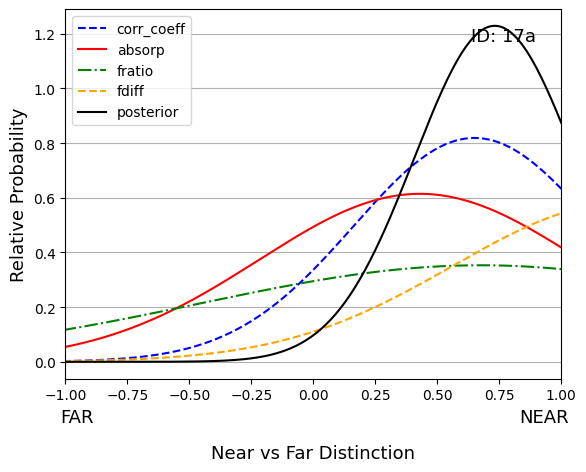

In [11]:
pdfvec=ppdf('17a')
plot_pdf('17a',pdfvec)

In [26]:
pdfvec.posterior

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
parameters, covariance = curve_fit(gaussian, x, pdfvec.posterior)

In [34]:
parameters

array([1.22855322, 0.73187434, 0.32472527])

1 [2.50170764e-263 4.51313873e-263 8.13946110e-263 ... 1.17371980e-238
 6.69178633e-239 3.81412164e-239]
2 [0. 0. 0. ... 0. 0. 0.]
3 [0. 0. 0. ... 0. 0. 0.]
4a [0. 0. 0. ... 0. 0. 0.]
4b [0. 0. 0. ... 0. 0. 0.]
5 [0. 0. 0. ... 0. 0. 0.]
6a [0. 0. 0. ... 0. 0. 0.]
6b [0. 0. 0. ... 0. 0. 0.]
7a [0. 0. 0. ... 0. 0. 0.]
7b [0. 0. 0. ... 0. 0. 0.]
8a [0. 0. 0. ... 0. 0. 0.]
8b [6.33967178e-141 1.14488282e-140 2.06642687e-140 ... 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
8c [0. 0. 0. ... 0. 0. 0.]
9 [0. 0. 0. ... 0. 0. 0.]
10 [0. 0. 0. ... 0. 0. 0.]
11a [0. 0. 0. ... 0. 0. 0.]
11b [0. 0. 0. ... 0. 0. 0.]
11c [0. 0. 0. ... 0. 0. 0.]
12 [0. 0. 0. ... 0. 0. 0.]
13 [0. 0. 0. ... 0. 0. 0.]
14 [0. 0. 0. ... 0. 0. 0.]
15 [0. 0. 0. ... 0. 0. 0.]
16a [nan nan nan ... nan nan nan]


/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_37103/1275257235.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_37103/1275257235.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  fratio_norm = integrate.quad(flux_ratio_gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id]))[0]
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_37103/1275257235.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested toleranc

16b [0. 0. 0. ... 0. 0. 0.]
17a [0. 0. 0. ... 0. 0. 0.]
17b [0. 0. 0. ... 0. 0. 0.]
17c [0. 0. 0. ... 0. 0. 0.]
18 [9.53681368e-65 1.10294014e-64 1.27546691e-64 ... 5.05503013e-63
 4.37931840e-63 3.79365563e-63]
19 [0. 0. 0. ... 0. 0. 0.]
20 [0. 0. 0. ... 0. 0. 0.]
21a [0. 0. 0. ... 0. 0. 0.]
21b [0. 0. 0. ... 0. 0. 0.]
22 [0. 0. 0. ... 0. 0. 0.]
23 [0. 0. 0. ... 0. 0. 0.]
24 [0. 0. 0. ... 0. 0. 0.]
25 [0. 0. 0. ... 0. 0. 0.]
26a [0. 0. 0. ... 0. 0. 0.]
26b [0. 0. 0. ... 0. 0. 0.]
27 [0. 0. 0. ... 0. 0. 0.]
28a [0. 0. 0. ... 0. 0. 0.]
28b [0. 0. 0. ... 0. 0. 0.]
28c [0. 0. 0. ... 0. 0. 0.]
29a [0. 0. 0. ... 0. 0. 0.]
29b [0. 0. 0. ... 0. 0. 0.]
30a [0. 0. 0. ... 0. 0. 0.]
30b [0. 0. 0. ... 0. 0. 0.]
31 [0. 0. 0. ... 0. 0. 0.]


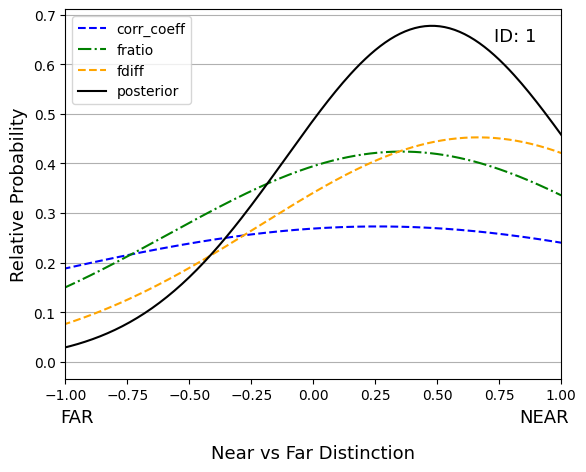

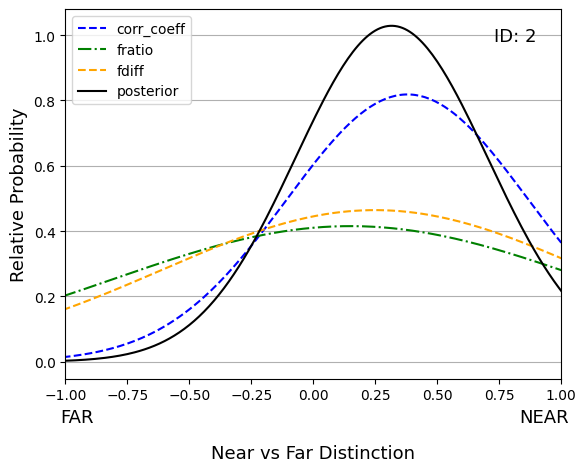

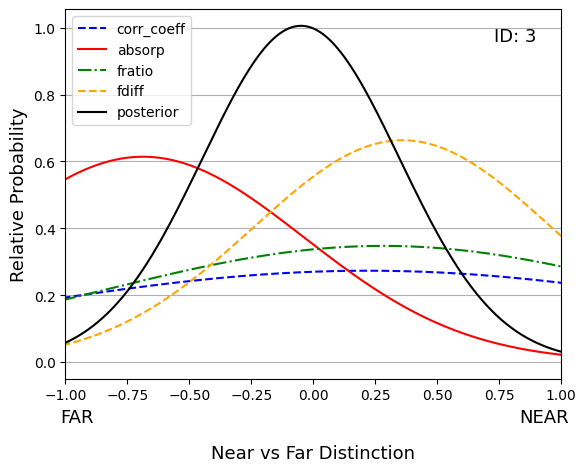

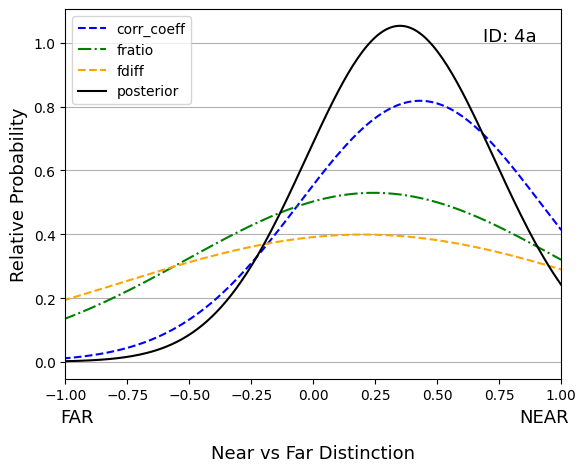

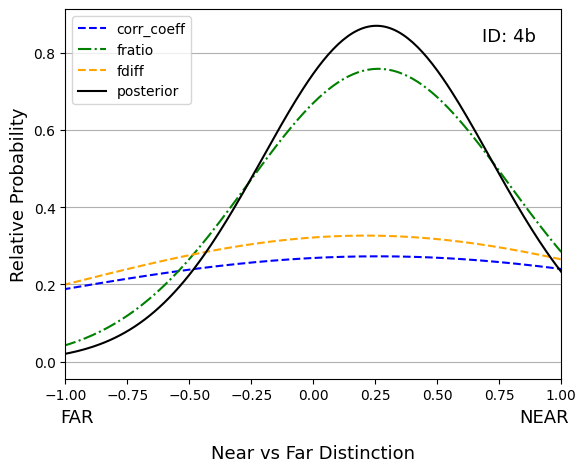

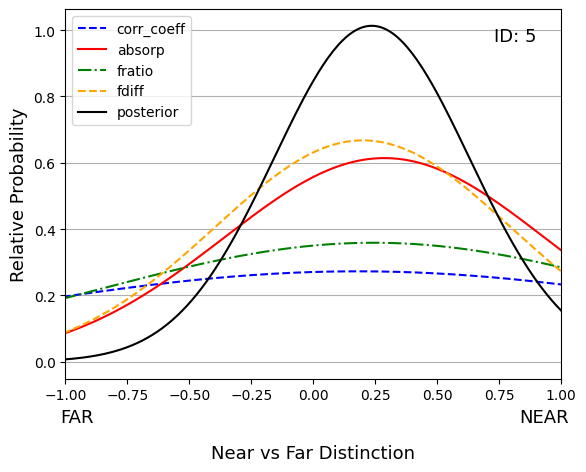

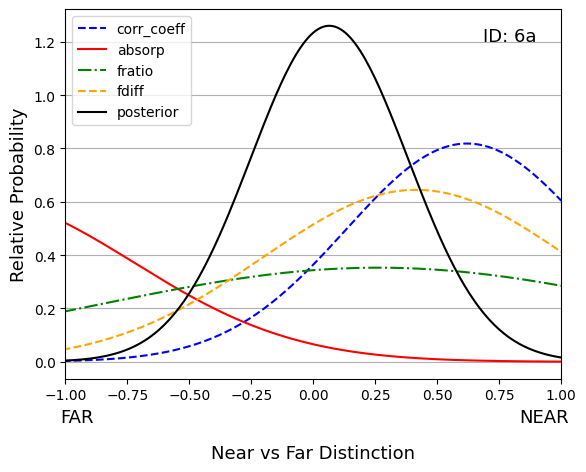

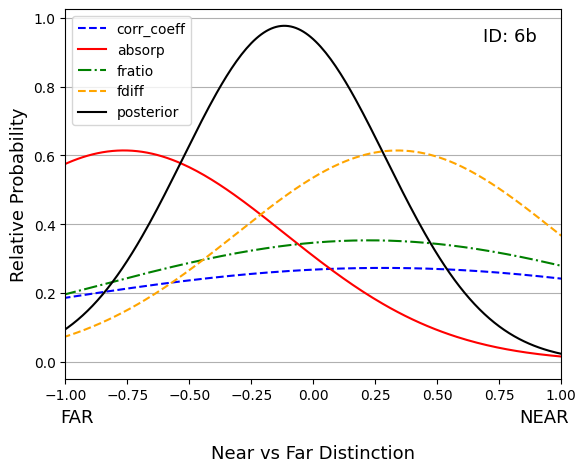

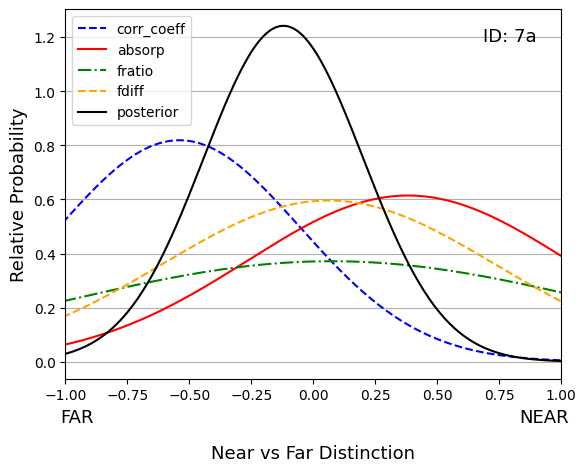

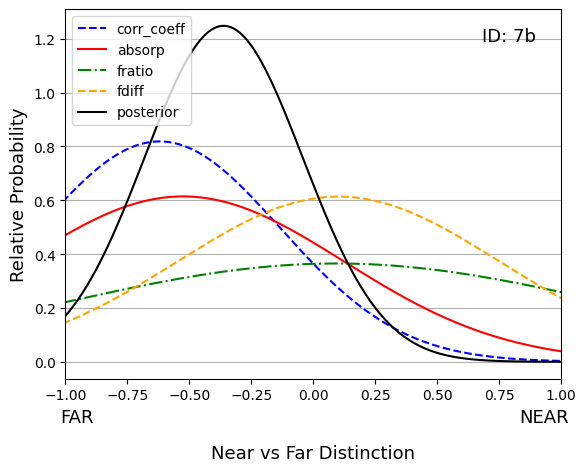

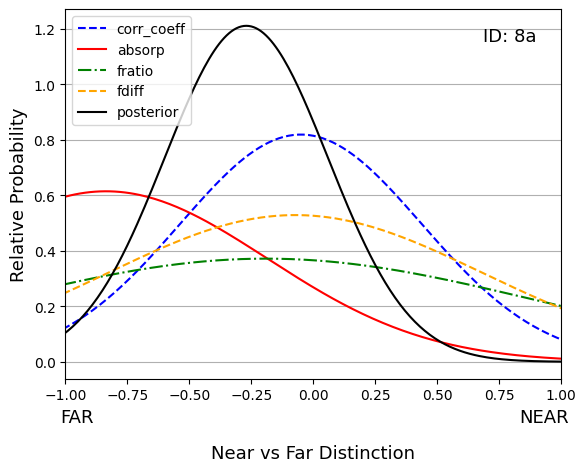

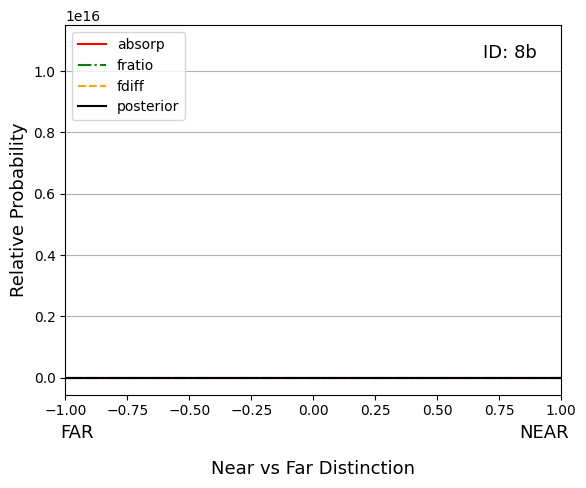

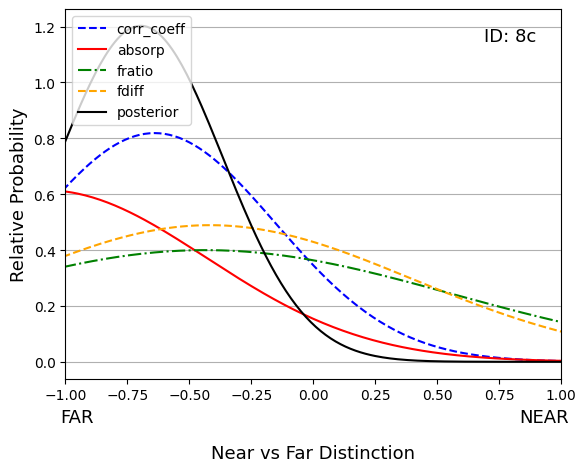

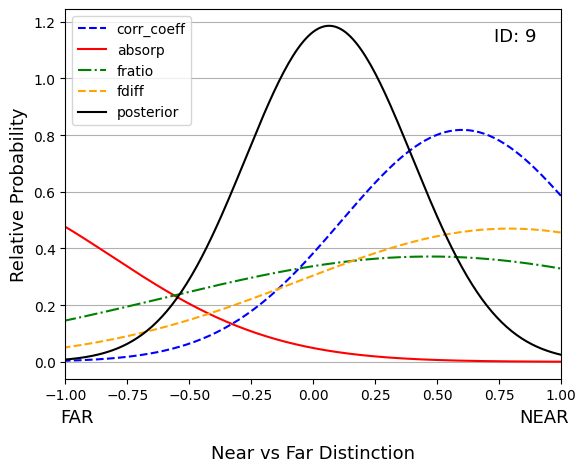

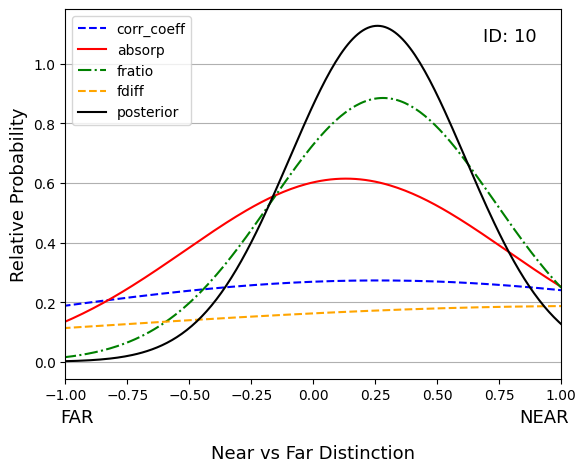

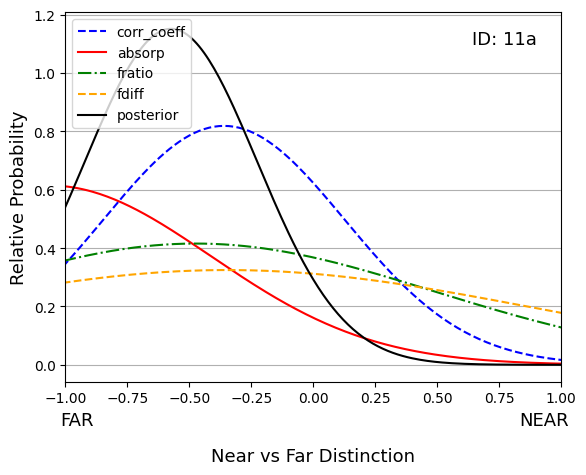

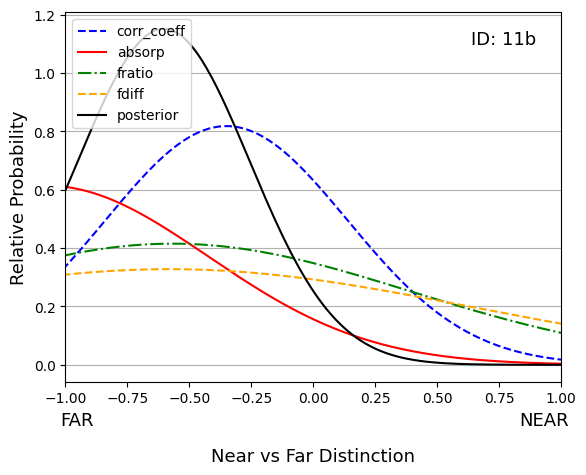

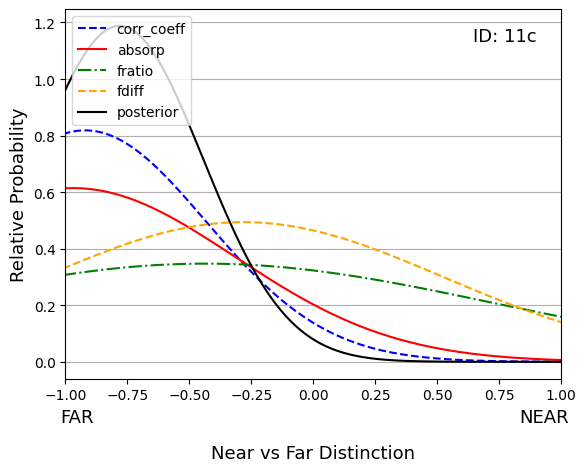

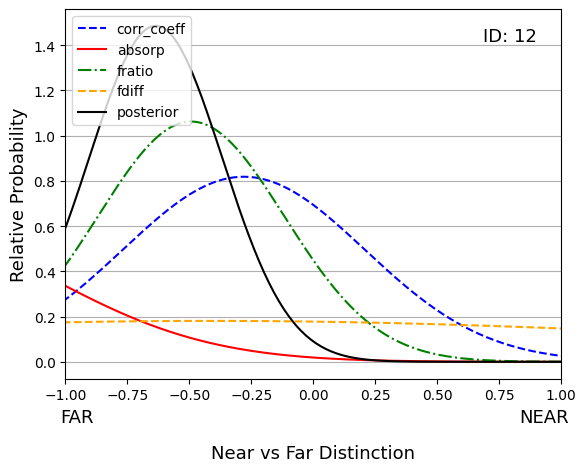

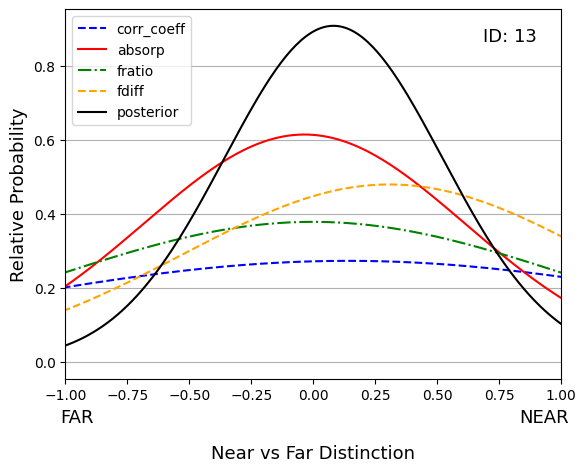

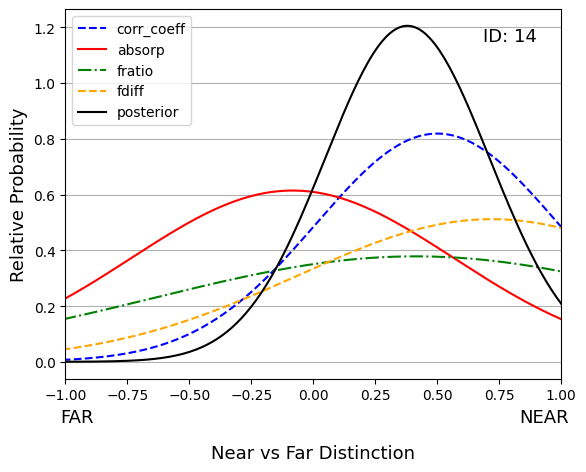

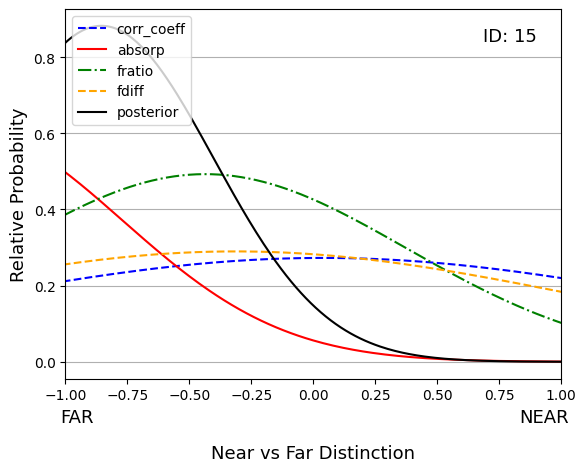

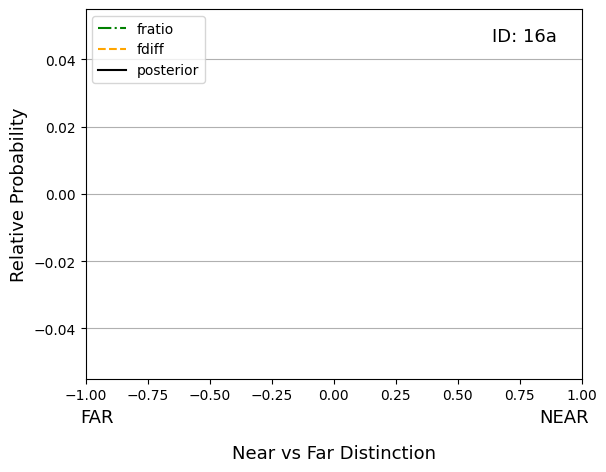

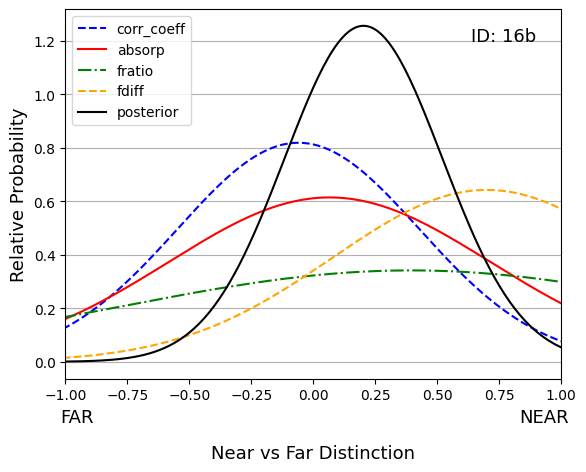

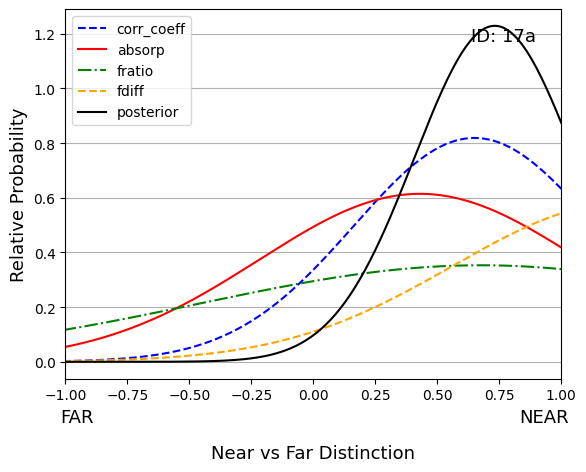

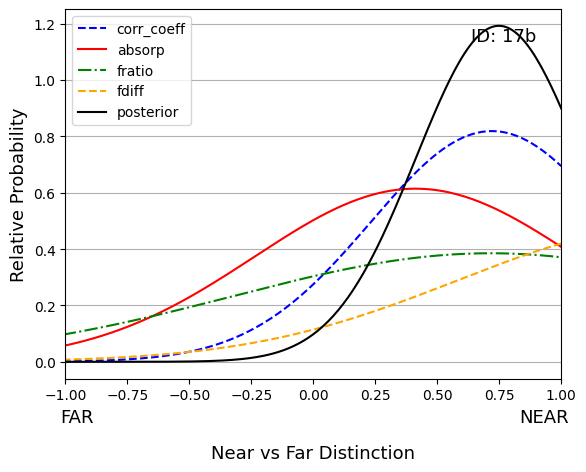

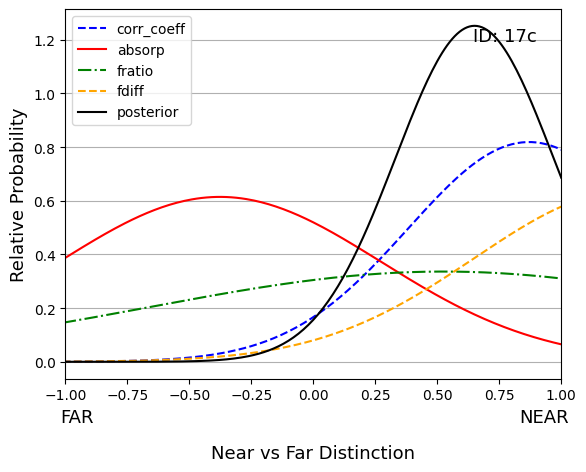

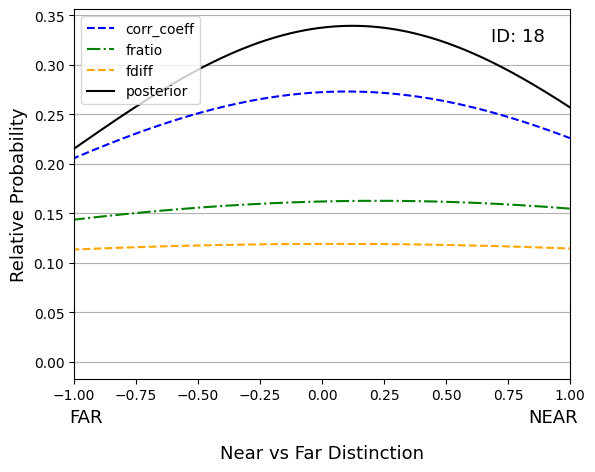

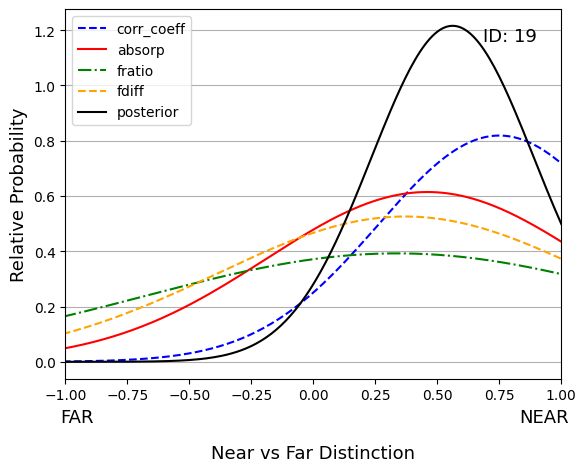

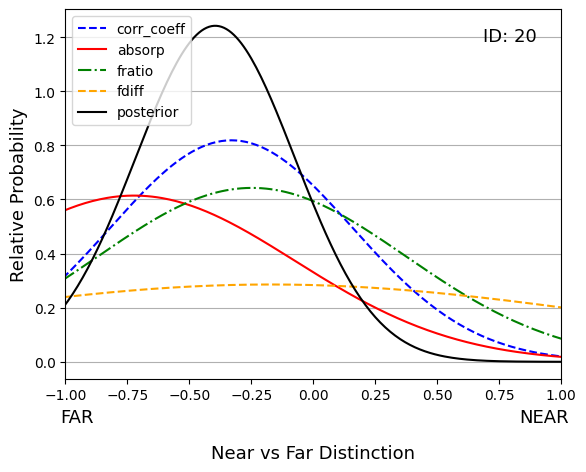

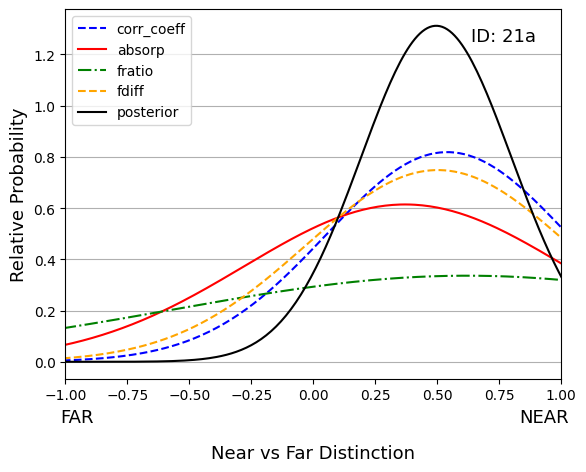

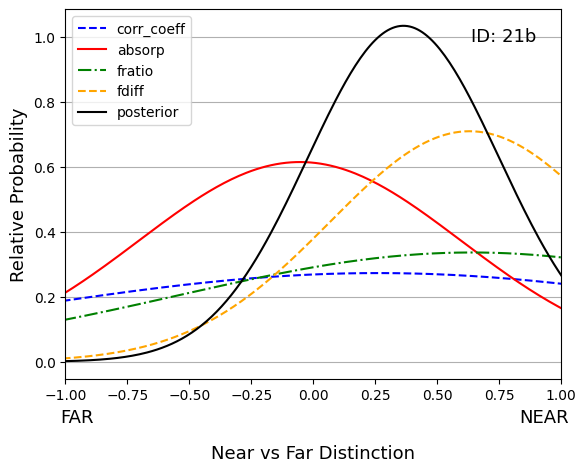

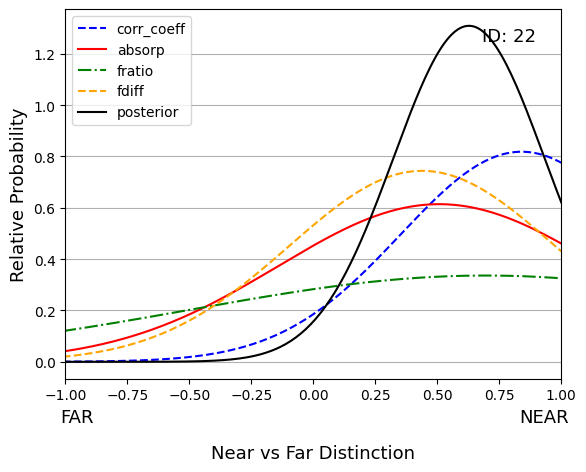

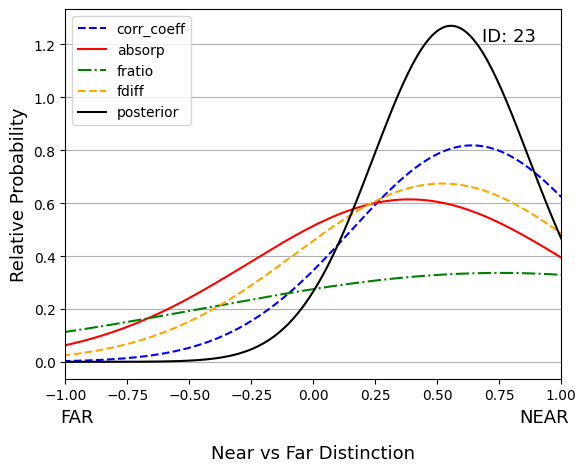

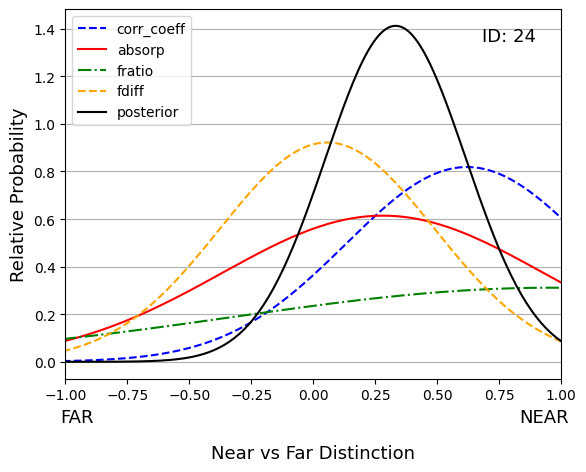

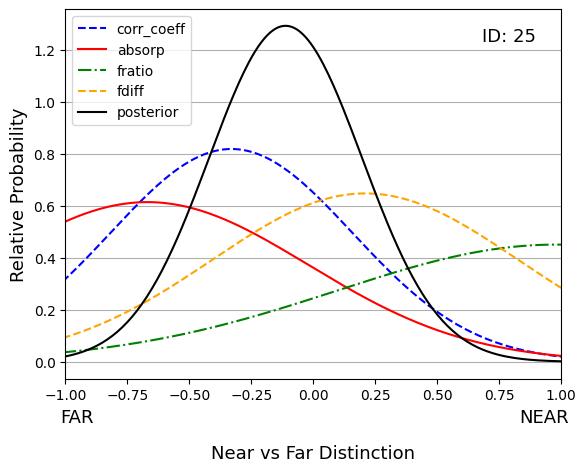

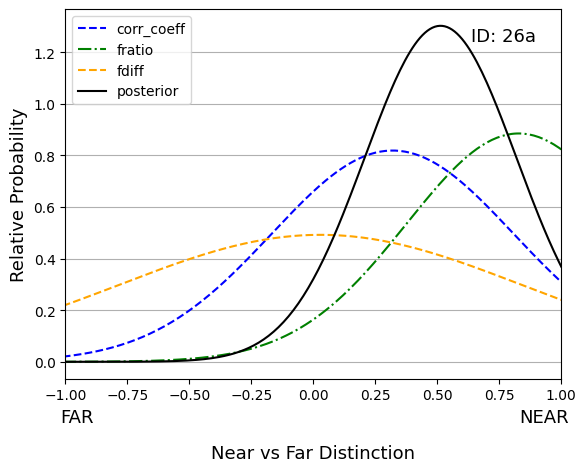

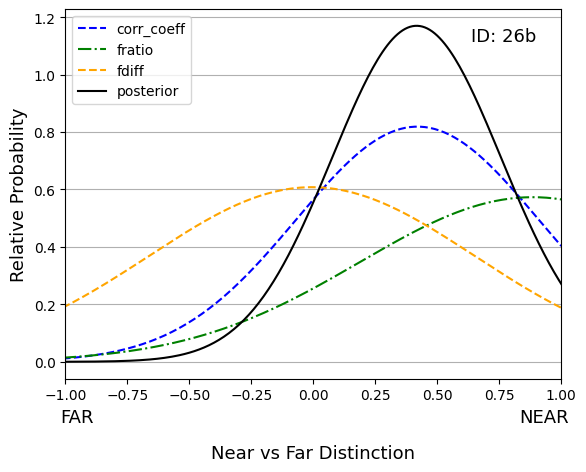

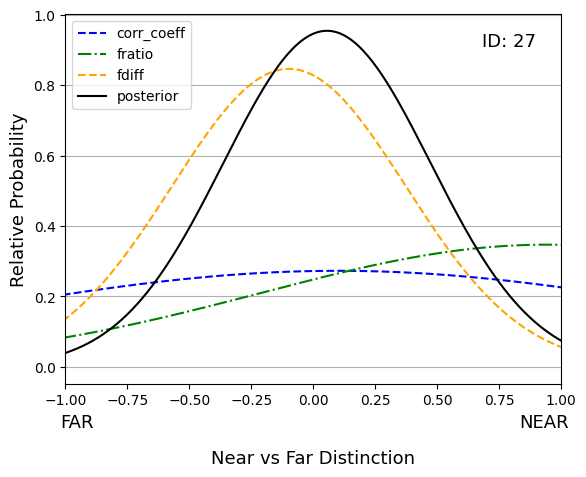

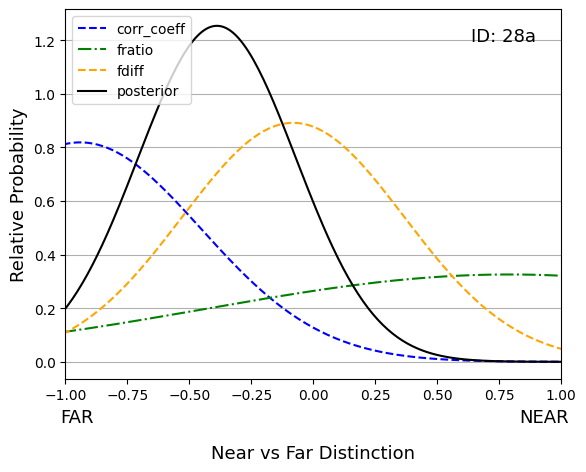

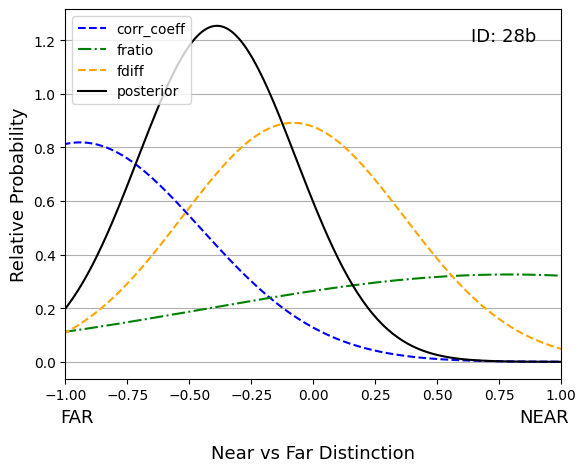

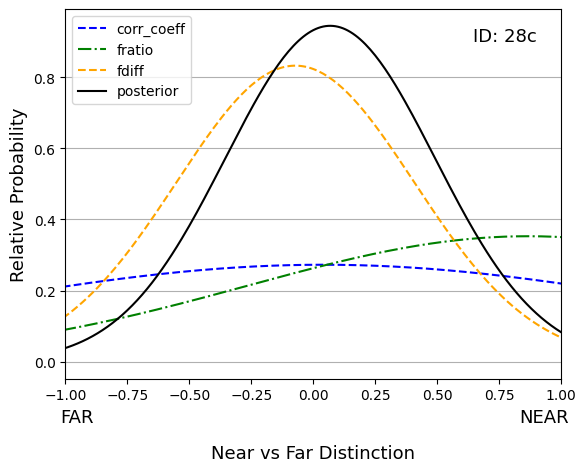

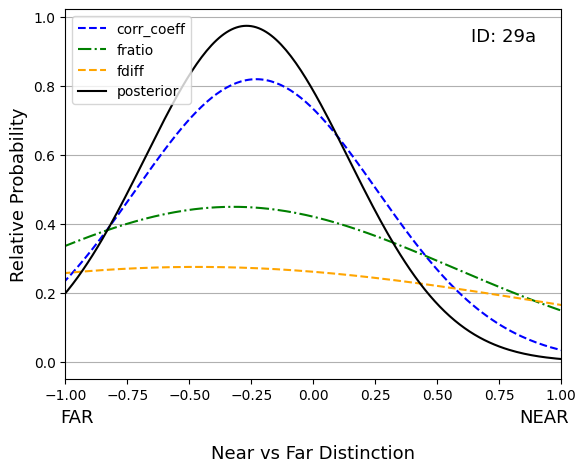

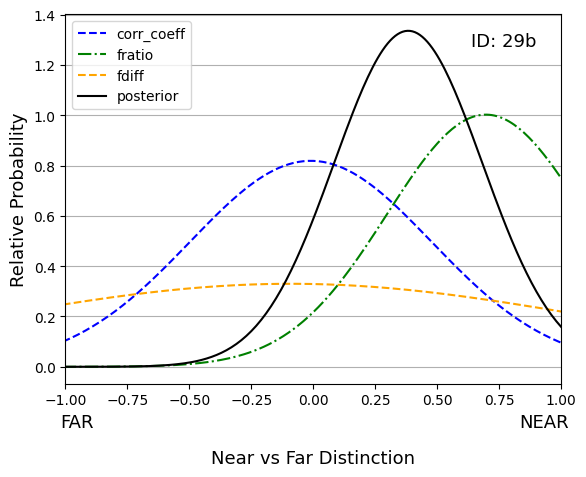

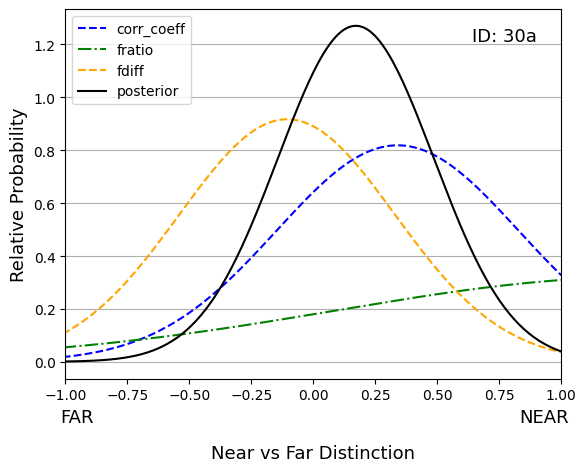

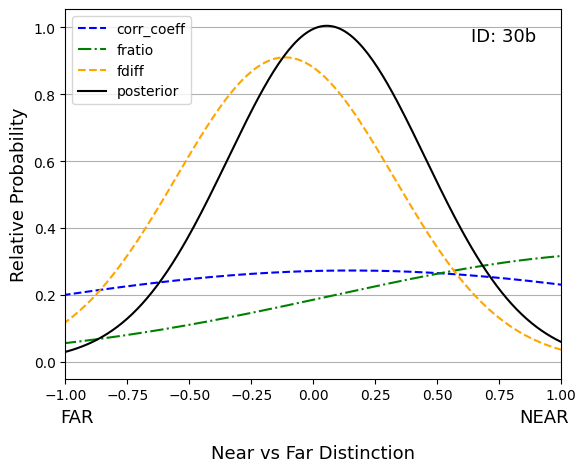

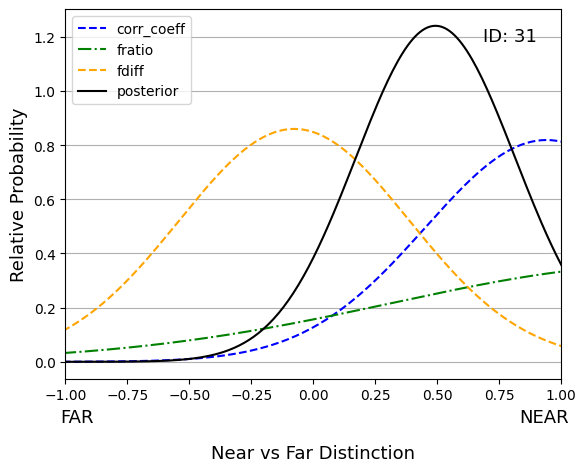

In [51]:
post_tab = Table()
A, mu, sigma = [], [], []

for i in cat_index:
    cat_id = np.where(cat_index == i)[0][0]
        
    pdfvec=ppdf(i)

    plot_pdf(i, pdfvec)
    if ~np.isnan(pdfvec.posterior).any() == True:
        parameters, covariance = curve_fit(gaussian, x, pdfvec.posterior)
        A.append(parameters[0])
        mu.append(parameters[1])
        sigma.append(parameters[2])
    else:
        A.append(np.nan)
        mu.append(np.nan)
        sigma.append(np.nan)
    
post_tab['A'] = A
post_tab['mu'] = mu
post_tab['sigma'] = sigma
    
post_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex", overwrite=True)

